In [1]:
import sys
sys.path.append("../..")
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import itertools
from func.iit_tpm import make_tpm, tpm_series, dis_mean
from func.grn_tpm import text_bn_graph, iit_tpm_cal

bnet = {
    ('A', 'B'): 'w_ab',
    ('B', 'A'): 'w_ba',
    ('A', 'C'): 'w_ac',
    ('C', 'A'): 'w_ca',
    ('B', 'C'): 'w_bc',
    ('C', 'B'): 'w_cb',
    ('A', 'A'): 'w_a',
    ('B', 'B'): 'w_b',
    ('C', 'C'): 'w_c',
    ('E1', 'A'): 'w1a',
    ('E1', 'B'): 'w1b',
    ('E1', 'C'): 'w1c',
    ('E2', 'A'): 'w2a',
    ('E2', 'B'): 'w2b',
    ('E2', 'C'): 'w2c',
}

In [3]:
import random
colors = ["#BB4F4F", '#2A69B3', '#74B38F', '#9B76B2', "#B99523", "#27B5AF", "#1E90FF", "#87CEEB"]

def decimal_to_binary(decimal, min_length=1):
    if min_length == 0:
        return ''
    if decimal == 0:
        return "0" if min_length == 1 else "0".zfill(min_length)
    binary = ""
    while decimal > 0:
        binary = str(decimal % 2) + binary
        decimal = decimal // 2
    # 使用 zfill 确保二进制字符串至少有 min_length 长度
    return binary.zfill(min_length)

def tpm_series2(tpm, init_state, steps):
    init_num = int(init_state, 2)
    serie = [init_num]
    serie_str = [init_state]
    for t in range(steps):
        num = serie[t]
        probabilities = tpm[num, :]
        sample = np.random.choice(range(len(probabilities)), p=probabilities)
        serie.append(sample)
        serie_str.append(decimal_to_binary(sample, min_length=int(np.log2(len(probabilities)))))
    return serie, serie_str

def serie_plot2(tpm, mech_size, en_size, en_series, init='111'):
    un_sys, un_en, syn, expansive, introverted, tpm_dic = iit_tpm_cal(tpm, mech_size=mech_size, en_size=en_size, dis=False)   
    strs = [decimal_to_binary(i, min_length=mech_size) for i in range(2**mech_size)] 
    long_serie = []
    init_state = init
    mark_serie = []
    mark = 0
    for en_list in en_series:
        en_state = en_list[0]
        steps = len(en_list)
        mark += steps
        mark_serie.append(mark)
        serie, serie_str = tpm_series2(tpm_dic[en_state], init_state, steps)
        init_state = serie_str[-1]
        long_serie += serie[:-1]
    return un_sys, un_en, syn, long_serie

def generate_random_sequence(n, length, seeds):
    res_ls = []
    for seed in seeds:
#         np.random.seed(seed)
#         random.seed(seed)
        result = []
        while len(result) < length:
            num = random.randint(0, n)
            if num not in result:
                result.append(num)
        res_ls.append(result)
    return res_ls

def shuffle_data(inputs, targets):
    # 生成随机索引
    indices = torch.randperm(len(inputs))
    # 根据随机索引打乱输入和目标
    shuffled_inputs = inputs[indices]
    shuffled_targets = targets[indices]
    return shuffled_inputs, shuffled_targets


((94, 2), (94,), 0.0)

In [4]:
w = 0.5
w1 = 0.5*(1 - w)
w2 = 1.5*(1 - w)
ww = {
    'w_ab': w,
    'w_ba': 0,
    'w_ac': 0,
    'w_ca': w,
    'w_bc': w,
    'w_cb': 0,
    'w_a': w,
    'w_b': w,
    'w_c': w,
    'w1a': w1,
    'w1b': w1,
    'w1c': w1,
    'w2a': w2,
    'w2b': w2,
    'w2c': w2
}
tpm, tpm_v = make_tpm(bnet, ww, k=25)

e_len = 2
n = 60
def int_to_one_hot(num, size=32):
    one_hot = [0] * size
    one_hot[num] = 1
    return one_hot

def make_data(tpm_v, n, e_len, seeds):
    batch0 = (2**e_len * n - 1)
    samples = batch0 * len(seeds) 
    inputs = np.zeros([samples, 32])
    target = np.zeros([samples])
    en_lss = generate_random_sequence(2**e_len-1, 2**e_len, seeds)
    init_lss = generate_random_sequence(7, 1, seeds)
    for en_ind, en_ls0 in enumerate(en_lss):
        row_ind = en_ind * batch0
        en_series = [[decimal_to_binary(k, min_length=e_len) for _ in range(n)] for k in en_ls0]
        n_sys, un_en, syn, long_serie = serie_plot2(tpm_v, 3, e_len, en_series, init=decimal_to_binary(init_lss[0][0], min_length=3))
        en_num_arr = np.array([[k for _ in range(n)] for k in en_ls0]).reshape(-1)
        long_arr = np.array(long_serie)
        data_arr = np.vstack((long_arr, en_num_arr))
        data_arr = data_arr[:, :-1].T
        for i in range(data_arr.shape[0]):
            inputs[row_ind+i, :] = int_to_one_hot(4*data_arr[i,0]+data_arr[i,1])
        target[en_ind*batch0:(en_ind+1)*batch0] = long_arr[1:].T
    return inputs, target, syn

def make_data2(tpm_v):
    inputs = np.zeros([samples, 32])
    target = np.zeros([samples])
    def generate_random_32d_one_hot():
        index = np.random.randint(0, 32)
        one_hot = np.zeros(32)
        one_hot[index] = 1
        return one_hot

    return inputs, target, syn


def test_syn(model):
    func = torch.nn.LogSoftmax(dim=0)
    tpm_trained = np.ones([32, 8])
    for i in range(8):
        for j in range(4):
            inputs = torch.tensor(int_to_one_hot(4*i+j)).float().to(device)
            tpm_trained[4*i+j,:] = np.exp(func(model(inputs)).cpu().data.numpy())

    un_sys, un_en, syn, expansive, introverted, tpm_dic = iit_tpm_cal(tpm_trained, mech_size=3, en_size=2, dis=True) 
    return syn, expansive, introverted

train_input, train_target, syn0 = make_data(tpm_v, n, e_len, seeds)
test_input, test_target, syn1 = make_data(tpm_v, n=10, e_len=2, seeds=[142])
train_input.shape, test_input.shape, syn0, syn1

((478, 32), (39, 32), 0.3863423437037241, 0.3863423437037241)

# Net

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.layer1 = nn.Linear(32, 64)
        self.relu = nn.ReLU()
        self.layer4 = nn.Linear(64, 16)
        self.layer2 = nn.Linear(16, 8)
        self.layer3 = nn.Linear(64, 64)
        self.dropout = nn.Dropout(p=0.5) 

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer3(x) + x
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer4(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        return x

In [8]:
w = 0.6
w1 = 0.5*(1 - w)
w2 = 1.5*(1 - w)
ww = {
    'w_ab': w,
    'w_ba': 0,
    'w_ac': 0,
    'w_ca': w,
    'w_bc': w,
    'w_cb': 0,
    'w_a': w,
    'w_b': w,
    'w_c': w,
    'w1a': w1,
    'w1b': w1,
    'w1c': w1,
    'w2a': w2,
    'w2b': w2,
    'w2c': w2
}
tpm, tpm_v = make_tpm(bnet, ww, k=25)
e_len = 2
n = 60

func = torch.nn.LogSoftmax(dim=1)
L = torch.nn.NLLLoss()
seeds = [1,2,3,4,5]
num_epochs = 10000
interval = 400
seed_data = range(20)
train_losses_arr = np.zeros([len(seeds), int(num_epochs/interval)])
syn_arr = np.zeros([len(seeds), int(num_epochs/interval)])
expan_arr = np.zeros([len(seeds), int(num_epochs/interval)])
intro_arr = np.zeros([len(seeds), int(num_epochs/interval)])
for m,seed in enumerate(seeds):
    train_input, train_target, syn0 = make_data(tpm_v, n, e_len, seed_data)
    test_input, test_target, syn1 = make_data(tpm_v, n=60, e_len=2, seeds=[42])
    torch.manual_seed(seed)
    model = Classifier()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    input_data = torch.tensor(train_input, dtype=float).float()
    targets = torch.tensor(train_target).long()
    test_input = torch.tensor(test_input, dtype=float).float() 
    test_target = torch.tensor(test_target).long()
    test_input, test_target = shuffle_data(test_input, test_target)
    # 训练循环
    train_losses = []
    test_losses = []
    syn_ls = []
    expan_ls = []
    intro_ls = []

    for epoch in range(num_epochs):
        outputs = model(input_data)
        # 计算损失
        y = func(outputs)
        loss = L(y, targets)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        # 更新参数
        optimizer.step()
        # 打印损失
        if (epoch + 1) % interval == 0:
            syn_t, expansive_t, introverted_t = test_syn(model)
            test_out = model(test_input)
            y = func(test_out)
            test_loss = L(y, test_target)
            train_losses.append(loss.item())
            test_losses.append(test_loss.item())
            syn_ls.append(syn_t)
            expan_ls.append(expansive_t)
            intro_ls.append(introverted_t)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}, Syn: {syn_t}, test_loss: {test_loss.item()}')
    train_losses_arr[m, :] = train_losses
    syn_arr[m, :] = syn_ls
    expan_arr[m, :] = expan_ls
    intro_arr[m, :] = intro_ls

Epoch [400/10000], Loss: 1.5007171630859375, Syn: 0.0191518671237509, test_loss: 1.492167592048645
Epoch [800/10000], Loss: 0.7652194499969482, Syn: 0.09851014479778557, test_loss: 0.7146402597427368
Epoch [1200/10000], Loss: 0.42918074131011963, Syn: 0.13911886297574205, test_loss: 0.40134215354919434
Epoch [1600/10000], Loss: 0.25569581985473633, Syn: 0.24012710431539397, test_loss: 0.25207218527793884
Epoch [2000/10000], Loss: 0.16107003390789032, Syn: 0.2148376250122174, test_loss: 0.18808183073997498
Epoch [2400/10000], Loss: 0.11169023811817169, Syn: 0.3170080292166587, test_loss: 0.1280525028705597
Epoch [2800/10000], Loss: 0.0793987289071083, Syn: 0.3058289039390506, test_loss: 0.09672874957323074
Epoch [3200/10000], Loss: 0.06495846807956696, Syn: 0.2887040973493757, test_loss: 0.15193700790405273
Epoch [3600/10000], Loss: 0.05959779769182205, Syn: 0.2730960851440622, test_loss: 0.16295434534549713
Epoch [4000/10000], Loss: 0.04792410880327225, Syn: 0.32357483704538686, test_l

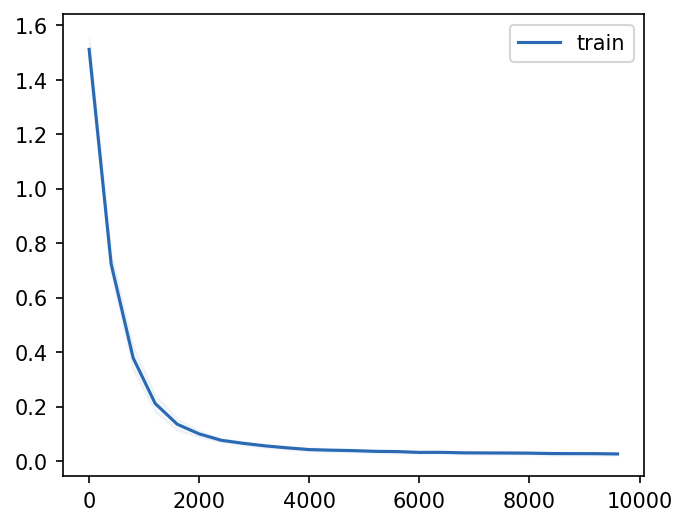

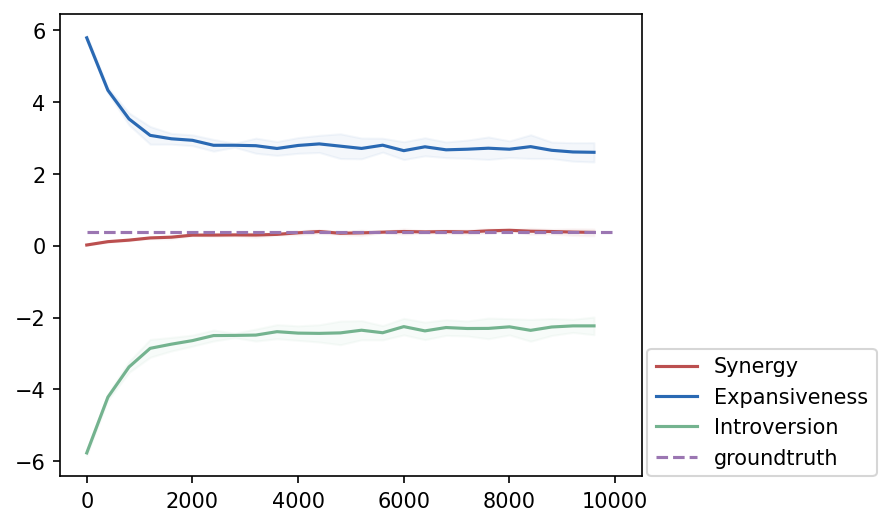

In [12]:
train_loss_mean = np.mean(train_losses_arr, axis=0)
train_loss_std = np.std(train_losses_arr, axis=0)
syn_mean = np.mean(syn_arr, axis=0)
syn_std = np.std(syn_arr, axis=0)
expan_mean = np.mean(expan_arr, axis=0)
expan_std = np.std(expan_arr, axis=0)
intro_mean = np.mean(intro_arr, axis=0)
intro_std = np.std(intro_arr, axis=0)
x_tick = [i * interval for i in range(len(train_loss_mean))]
plt.figure(figsize=(5,4),dpi=150)
plt.plot(x_tick, train_loss_mean, color=colors[1], label="train")
plt.fill_between(x_tick, train_loss_mean+train_loss_std, train_loss_mean-train_loss_std, color=colors[1], alpha=0.05)
plt.legend()
plt.show()

plt.figure(figsize=(5,4),dpi=150)
plt.plot(x_tick, syn_mean, color=colors[0], label="Synergy")
plt.fill_between(x_tick, syn_mean+syn_std, syn_mean-syn_std, color=colors[0], alpha=0.05)
plt.plot(x_tick, expan_mean, color=colors[1], label="Expansiveness")
plt.fill_between(x_tick, expan_mean+expan_std, expan_mean-expan_std, color=colors[1], alpha=0.05)
plt.plot(x_tick, intro_mean, color=colors[2], label="Introversion")
plt.fill_between(x_tick, intro_mean+intro_std, intro_mean-intro_std, color=colors[2], alpha=0.05)
plt.plot([0, len(train_losses)*interval], [syn0, syn1], color=colors[3], linestyle='--', label="groundtruth")
plt.legend(loc=[1.01,0])
plt.show()

100%|██████████| 20/20 [00:00<00:00, 36.85it/s]


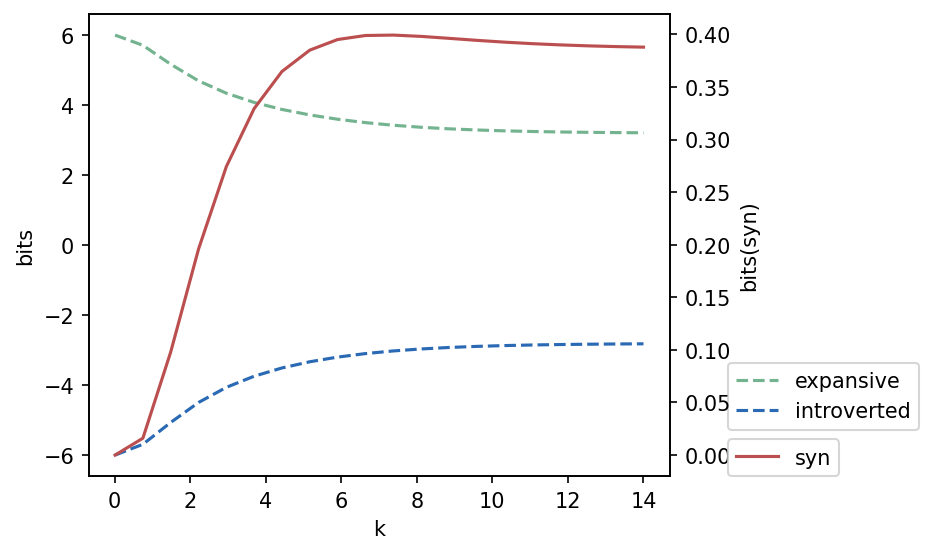

In [10]:
from tqdm import tqdm
colors = ["#BB4F4F", '#2A69B3', '#74B38F', '#9B76B2', "#B99523", "#27B5AF", "#1E90FF", "#87CEEB"]
w = 0.5
w1 = 0.5*(1 - w)
w2 = 1.5*(1 - w)
ww = {
    'w_ab': w,
    'w_ba': 0,
    'w_ac': 0,
    'w_ca': w,
    'w_bc': w,
    'w_cb': 0,
    'w_a': w,
    'w_b': w,
    'w_c': w,
    'w1a': w1,
    'w1b': w1,
    'w1c': w1,
    'w2a': w2,
    'w2b': w2,
    'w2c': w2
}

syn_list = []
expan_list = []
intro_list = []
k_axis = np.linspace(0.01, 14, 20)
for k in tqdm(k_axis):
    tpm, tpm_v = make_tpm(bnet, ww, k=k)
    un_sys, un_en, syn, expansive, introverted, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2, dis=False) 
    syn_list.append(syn)
    expan_list.append(expansive)
    intro_list.append(introverted)
    
plt.figure(figsize=(5,4),dpi=150)

# 绘制第一条线，关联到左边的 y 轴
ax1 = plt.gca()  # 获取当前坐标轴
plt.plot(k_axis, expan_list, label='expansive', linestyle="--", color=colors[2])
plt.plot(k_axis, intro_list, label="introverted", linestyle='--', color=colors[1])
plt.legend(loc=[1.1, 0.1])
# 绘制第二条线，关联到右边的 y 轴
ax2 = ax1.twinx()  # 创建与 ax1 共享 x 轴的新坐标轴
plt.plot(k_axis, syn_list, label='syn', color=colors[0])

plt.xlabel('k')

# 设置左边 y 轴的标签
ax1.set_ylabel('bits')  

# 设置右边 y 轴的标签
ax2.set_ylabel('bits(syn)')  
ax1.set_xlabel('k')
ax2.set_xlabel('k')
plt.legend(loc=[1.1, 0])
plt.show()

In [ ]:
e_len = 2
n = 12
func = torch.nn.LogSoftmax(dim=1)
L = torch.nn.NLLLoss()
seeds = range(10)
num_epochs = 10000
interval = 1000
seed_data = range(100)
syn_mean_list = []
expan_mean_list = []
intro_mean_list = []
syn_std_list = []
expan_std_list = []
intro_std_list = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")
k_axis = np.linspace(0.01, 14, 14)
batch_size = 32
for k in tqdm(k_axis):
    tpm, tpm_v = make_tpm(bnet, ww, k=k)
    train_losses_arr = np.zeros([len(seeds), int(num_epochs/interval)])
    syn_arr = np.zeros([len(seeds), int(num_epochs/interval)])
    expan_arr = np.zeros([len(seeds), int(num_epochs/interval)])
    intro_arr = np.zeros([len(seeds), int(num_epochs/interval)])
    random.seed(0)
    np.random.seed(0)
    train_input, train_target, syn0 = make_data(tpm_v, n, e_len, seed_data)
    for m,seed in tqdm(enumerate(seeds)):
        random.seed(seed)
        np.random.seed(seed)
#         test_input, test_target, syn1 = make_data(tpm_v, n=60, e_len=2, seeds=[42])
        torch.manual_seed(seed)
        model = Classifier().to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.0001)
        input_data = torch.tensor(train_input, dtype=float).float().to(device)
        targets = torch.tensor(train_target).long().to(device)
        num_batches = len(input_data) // batch_size
#         test_input = torch.tensor(test_input, dtype=float).float() .to(device)
#         test_target = torch.tensor(test_target).long().to(device)
        input_data, targets = shuffle_data(input_data, targets)
        train_losses = []
        test_losses = []
        syn_ls = []
        expan_ls = []
        intro_ls = []

        for epoch in range(num_epochs):
            for batch in range(num_batches):
                start_idx = batch * batch_size
                end_idx = start_idx + batch_size
                batch_input = input_data[start_idx:end_idx]
                batch_targets = targets[start_idx:end_idx]
                
                outputs = model(batch_input)
                y = func(outputs)
                loss = L(y, batch_targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            if (epoch + 1) % interval == 0:
                syn_t, expansive_t, introverted_t = test_syn(model)
#                 test_out = model(test_input)
#                 y = func(test_out)
#                 test_loss = L(y, test_target)
                train_losses.append(loss.item())
#                 test_losses.append(test_loss.item())
                syn_ls.append(syn_t)
                expan_ls.append(expansive_t)
                intro_ls.append(introverted_t)
                #print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}, Syn: {syn_t}, test_loss: {test_loss.item()}')
        train_losses_arr[m, :] = train_losses
        syn_arr[m, :] = syn_ls
        expan_arr[m, :] = expan_ls
        intro_arr[m, :] = intro_ls
    syn_mean_list.append(np.mean(syn_arr, axis=0)[-1])
    syn_std_list.append(np.std(syn_arr, axis=0)[-1])
    expan_mean_list.append(np.mean(expan_arr, axis=0)[-1])
    expan_std_list.append(np.std(expan_arr, axis=0)[-1])
    intro_mean_list.append(np.mean(intro_arr, axis=0)[-1])
    intro_std_list.append(np.std(intro_arr, axis=0)[-1])

Training on device: cuda:0


  0%|          | 0/14 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [1:17:05, 4625.63s/it]

In [ ]:
np.save("syn_mean_list.npy", syn_mean_list)
np.save("expan_mean_list.npy", expan_mean_list)
np.save("intro_mean_list.npy", intro_mean_list)
np.save("syn_std_list.npy", syn_std_list)
np.save("expan_std_list.npy", expan_std_list)
np.save("intro_std_list.npy", intro_std_list)

In [ ]:
w = 0.5
w1 = 0.5*(1 - w)
w2 = 1.5*(1 - w)
ww = {
    'w_ab': w,
    'w_ba': 0,
    'w_ac': 0,
    'w_ca': w,
    'w_bc': w,
    'w_cb': 0,
    'w_a': w,
    'w_b': w,
    'w_c': w,
    'w1a': w1,
    'w1b': w1,
    'w1c': w1,
    'w2a': w2,
    'w2b': w2,
    'w2c': w2
}

syn_list = []
expan_list = []
intro_list = []
k_axis = np.linspace(0.01, 14, 14)
for k in tqdm(k_axis):
    tpm, tpm_v = make_tpm(bnet, ww, k=k)
    un_sys, un_en, syn, expansive, introverted, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2, dis=False) 
    syn_list.append(syn)
    expan_list.append(expansive)
    intro_list.append(introverted)
    
plt.figure(figsize=(5,4),dpi=150)

# 绘制第一条线，关联到左边的 y 轴
ax1 = plt.gca()  # 获取当前坐标轴
plt.plot(k_axis, expan_list, label='Expansiveness', color=colors[2])
plt.plot(k_axis, intro_list, label="Introversion", color=colors[1])
plt.plot(k_axis, expan_mean_list, label='Expansiveness_trained', linestyle="--", color=colors[2])
plt.plot(k_axis, intro_mean_list, label="Introversion_trained", linestyle='--', color=colors[1])
plt.fill_between(k_axis, np.array(expan_mean_list)-np.array(expan_std_list), np.array(expan_mean_list)+np.array(expan_std_list), alpha=0.2, color=colors[2])
plt.fill_between(k_axis, np.array(intro_mean_list)-np.array(intro_std_list), np.array(intro_mean_list)+np.array(intro_std_list), alpha=0.2, color=colors[1])
plt.legend(loc=[1.15, 0.15])
# 绘制第二条线，关联到右边的 y 轴
ax2 = ax1.twinx()  # 创建与 ax1 共享 x 轴的新坐标轴
plt.plot(k_axis, syn_list, label='Synergy', color=colors[0])
plt.plot(k_axis, syn_mean_list, label='Synergy_trained', linestyle="--", color=colors[0])
plt.fill_between(k_axis, np.array(syn_mean_list)-np.array(syn_std_list), np.array(syn_mean_list)+np.array(syn_std_list), alpha=0.2, color=colors[0])
plt.xlabel('k')
ax1.set_ylabel('Bits')  
ax2.set_ylabel('Bits(Synergy)')  
ax1.set_xlabel('k')
ax2.set_xlabel('k')
plt.legend(loc=[1.15, 0])
plt.show()